<a href="https://colab.research.google.com/github/it22258380/DL-Assignment/blob/feature%2FTharinda/afterGRUtraining_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages (if not already installed)
!pip install pandas numpy matplotlib scikit-learn tensorflow kaggle

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rasulmah/sri-lanka-weather-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'sri-lanka-weather-dataset' dataset.
Path to dataset files: /kaggle/input/sri-lanka-weather-dataset


In [ ]:
# Example path - change to your actual path
data_path = "/kaggle/input/sri-lanka-weather-dataset/SriLanka_Weather_Dataset.csv"

df = pd.read_csv(data_path)
print("✅ Data loaded successfully!")
df.head()

✅ Data loaded successfully!


,time,weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,...,precipitation_hours,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,et0_fao_evapotranspiration,latitude,longitude,elevation,country,city
0,2010-01-01,2,30.0,22.7,26.1,34.4,25.2,29.2,2010-01-01T00:52,2010-01-01T12:35,...,0.0,11.7,27.4,20,4.58,7.0,79.899994,16.0,Sri Lanka,Colombo
1,2010-01-02,51,29.9,23.5,26.2,33.8,26.2,29.8,2010-01-02T00:52,2010-01-02T12:36,...,1.0,13.0,27.0,24,3.84,7.0,79.899994,16.0,Sri Lanka,Colombo
2,2010-01-03,51,29.5,23.2,26.0,34.3,26.3,29.9,2010-01-03T00:53,2010-01-03T12:36,...,3.0,12.3,27.4,16,3.65,7.0,79.899994,16.0,Sri Lanka,Colombo
3,2010-01-04,2,28.9,21.9,25.3,31.6,23.4,27.8,2010-01-04T00:53,2010-01-04T12:37,...,0.0,17.0,34.6,356,3.79,7.0,79.899994,16.0,Sri Lanka,Colombo
4,2010-01-05,1,28.1,21.3,24.5,30.1,23.1,26.1,2010-01-05T00:53,2010-01-05T12:37,...,0.0,18.7,37.1,355,4.97,7.0,79.899994,16.0,Sri Lanka,Colombo


In [ ]:
# Check basic info
print(df.info())
print(df.describe())

# Check for missing values
print("\nMissing values per column:\n", df.isnull().sum())

# Drop rows or fill missing values
df = df.dropna()  # or df.fillna(method='ffill', inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147480 entries, 0 to 147479
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   time                        147480 non-null  object 
 1   weathercode                 147480 non-null  int64  
 2   temperature_2m_max          147480 non-null  float64
 3   temperature_2m_min          147480 non-null  float64
 4   temperature_2m_mean         147480 non-null  float64
 5   apparent_temperature_max    147480 non-null  float64
 6   apparent_temperature_min    147480 non-null  float64
 7   apparent_temperature_mean   147480 non-null  float64
 8   sunrise                     147480 non-null  object 
 9   sunset                      147480 non-null  object 
 10  shortwave_radiation_sum     147480 non-null  float64
 11  precipitation_sum           147480 non-null  float64
 12  rain_sum                    147480 non-null  float64
 13  snowfall_sum  

In [ ]:
# Sort by date
df = df.sort_values(by='time')

# Keep only numeric columns (excluding Date)
df_features = df[['temperature_2m_mean', 'precipitation_sum', 'windspeed_10m_max', 'windgusts_10m_max']]
target = df['weathercode']

In [ ]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_x.fit_transform(df_features)
y_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1))


In [ ]:
def create_sequences(X, y, time_steps=30):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 30  # You can adjust this (e.g., 7, 14, 60)
X_seq, y_seq = create_sequences(X_scaled, y_scaled, TIME_STEPS)
print("✅ Sequence shape:", X_seq.shape, y_seq.shape)


✅ Sequence shape: (147450, 30, 4) (147450, 1)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, shuffle=False
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Training samples: 117960
Testing samples: 29490


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

# Define the GRU model
model = Sequential([
    GRU(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    GRU(64, activation='tanh'),
    Dropout(0.2),
    Dense(1)  # Output layer (predicts next wind speed)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 30, 128)        │        51,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,769 (346.75 KB)

 Trainable params: 88,769 (346.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 50
BATCH_SIZE = 32

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)


Epoch 1/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 247s 65ms/step - loss: 0.0971 - val_loss: 0.0590
Epoch 2/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 244s 66ms/step - loss: 0.0675 - val_loss: 0.0548
Epoch 3/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 253s 69ms/step - loss: 0.0655 - val_loss: 0.0635
Epoch 4/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 256s 67ms/step - loss: 0.0634 - val_loss: 0.0517
Epoch 5/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 244s 66ms/step - loss: 0.0638 - val_loss: 0.0512
Epoch 6/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 244s 66ms/step - loss: 0.0630 - val_loss: 0.0521
Epoch 7/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 246s 67ms/step - loss: 0.0620 - val_loss: 0.0507
Epoch 8/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 252s 68ms/step - loss: 0.0620 - val_loss: 0.0505
Epoch 9/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 248s 67ms/step - loss: 0.0609 - val_loss: 0.0514
Epoch 10/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 244s 66ms/step - loss: 0.0608 - val_loss: 0.0580
Epoch 11/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 244s 66ms/step - loss: 0.0607 - val_loss: 0.05

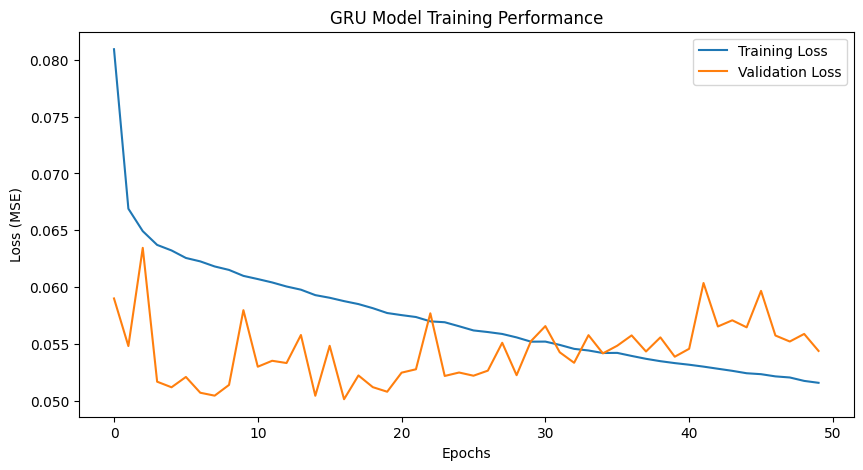

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('GRU Model Training Performance')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


In [ ]:
# Predict
y_pred_scaled = model.predict(X_test)

# Inverse scaling
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

# Show comparison
print("✅ Predictions generated successfully!")


922/922 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step
✅ Predictions generated successfully!


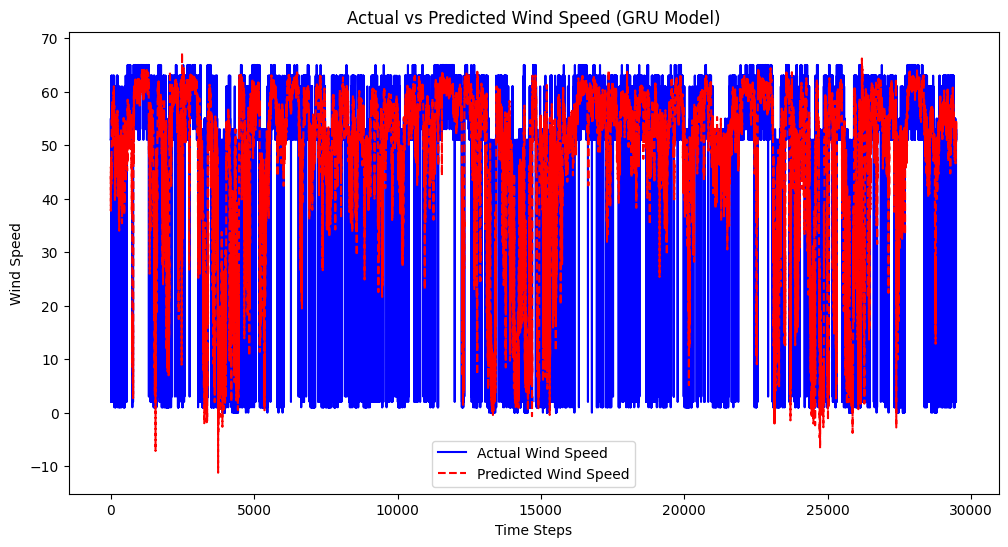

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Actual Wind Speed', color='blue')
plt.plot(y_pred, label='Predicted Wind Speed', color='red', linestyle='--')
plt.title('Actual vs Predicted Wind Speed (GRU Model)')
plt.xlabel('Time Steps')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"🌬️ Wind Speed Forecasting RMSE: {rmse:.3f}")


🌬️ Wind Speed Forecasting RMSE: 15.159
